# Erstellen einer Umsatzprognose

© Thomas Robert Holy 2019
<br>
Version 0.0.1
<br><br>
Visit me on GitHub: https://github.com/trh0ly

## Import Packages

In [1]:
#----------------
# Web Scrap
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import re
import string

#----------------
# Regression
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

#----------------
# Prognose-Tool
from fbprophet import Prophet

#----------------
# Verschiedenes
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import datetime

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.width', 350)

## Definition einer Hilfsfunktion zum plotten

In [4]:
def make_plot(model, X, y):

    plt.rcParams['figure.figsize'] = (32, 16) # macht die Plots größer
    plt.scatter(X, y,  color='gray', label='Wahrer Wert') # Scatterplot mit wahren Werten erstellen  
    plt.scatter(X, pred, color='red', label='Prognostizierter Wert') # Scatterplot mit prognostizierten Werten erstellen  
    line = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1) # Datenpunkte erzeugen für das Modell
    plt.plot(line, model.predict(line), color='green', label='Modell') # Plotten des Modells
    # Beschriften
    plt.title('Umsatzprognose')  
    plt.xlabel('Verstrichene Zeiteinheiten (Quartale)')  
    plt.ylabel('Umsatz (in $)')
    plt.legend(loc='upper left')
    plt.show()

## Datenbeschaffung und Manipulation

### Web Scrap historischer Daten von Statista

In [5]:
"""
#url = 'https://www.statista.com/statistics/273963/quarterly-revenue-of-amazoncom/' # Amazon
#url = 'https://www.statista.com/statistics/263427/apples-net-income-since-first-quarter-2005/' # Apple
url = 'https://www.statista.com/statistics/323046/alibaba-quarterly-group-revenue/' # Alibaba

html = requests.get(url)
soup = BeautifulSoup(html.text, 'lxml')

chart = soup.find("tbody")
children = chart.find_all("tr")

data = []
for tag in children:
    data_tuple = (tag.text[:6],tag.text[6:])
    data.append(data_tuple)

quartals, revenues = [], []
for i in range(0, len(data)):
    x = data[i][0]
    y = data[i][1]
    quartal = x.replace(' ', '')
    y = y.replace(',', '.')
    revenue = float(y)
    quartals.append(quartal)
    revenues.append(revenue)

quartals = quartals[::-1]
revenues = revenues[::-1]
print(quartals)
print(revenues)
"""

'\n#url = \'https://www.statista.com/statistics/273963/quarterly-revenue-of-amazoncom/\' # Amazon\n#url = \'https://www.statista.com/statistics/263427/apples-net-income-since-first-quarter-2005/\' # Apple\nurl = \'https://www.statista.com/statistics/323046/alibaba-quarterly-group-revenue/\' # Alibaba\n\nhtml = requests.get(url)\nsoup = BeautifulSoup(html.text, \'lxml\')\n\nchart = soup.find("tbody")\nchildren = chart.find_all("tr")\n\ndata = []\nfor tag in children:\n    data_tuple = (tag.text[:6],tag.text[6:])\n    data.append(data_tuple)\n\nquartals, revenues = [], []\nfor i in range(0, len(data)):\n    x = data[i][0]\n    y = data[i][1]\n    quartal = x.replace(\' \', \'\')\n    y = y.replace(\',\', \'.\')\n    revenue = float(y)\n    quartals.append(quartal)\n    revenues.append(revenue)\n\nquartals = quartals[::-1]\nrevenues = revenues[::-1]\nprint(quartals)\nprint(revenues)\n'

### DataFrame mit den Daten erzeugen und Überprüfen

In [6]:
#----------------------------------------
# Daten als Array manuell gespeichert 

"""
#-----------------------
# Amazon

quartals = ["Q1'07", "Q2'07", "Q3'07", "Q4'07", "Q1'08", "Q2'08", "Q3'08", "Q4'08", "Q1'09", "Q2'09",
            "Q3'09", "Q4'09", "Q1'10", "Q2'10", "Q3'10", "Q4'10", "Q1'11", "Q2'11", "Q3'11", "Q4'11",
            "Q1'12", "Q2'12", "Q3'12", "Q4'12", "Q1'13", "Q2'13", "Q3'13", "Q4'13", "Q1'14", "Q2'14",
            "Q3'14", "Q4'14", "Q1'15", "Q2'15", "Q3'15", "Q4'15", "Q1'16", "Q2'16", "Q3'16", "Q4'16",
            "Q1'17", "Q2'17", "Q3'17", "Q4'17", "Q1'18", "Q2'18", "Q3'18", "Q4'18", "Q1'19", "Q2'19"]

revenues = [3.02, 2.89, 3.26, 5.67, 4.14, 4.06, 4.26, 6.7, 4.89, 4.65, 5.45, 9.52, 7.13, 6.57, 7.56,
            12.95, 9.86, 9.91, 10.88, 17.43, 13.19, 12.83, 13.81, 21.27, 16.07, 15.7, 17.09, 25.59,
            19.74, 19.34, 20.58, 29.33, 22.72, 23.19, 25.36, 35.75, 29.13, 30.4, 32.71, 43.74, 35.71,
            37.96, 43.74, 60.5, 51.04, 52.89, 56.58, 72.38, 59.7, 63.4]

"""
#-----------------------
# Alibaba Group

quartals = ["Q2'13", "Q3'13", "Q4'13", "Q1'14", "Q2'14", "Q3'14", "Q4'14", "Q1'15", "Q2'15", "Q3'15", "Q4'15",
            "Q1'16", "Q2'16", "Q3'16", "Q4'16", "Q1'17", "Q2'17", "Q3'17", "Q4'17", "Q1'18", "Q2'18", "Q3'18",
            "Q4'18", "Q1'19", "Q2'19"]

revenues = [10.778, 10.95, 18.745, 12.031, 15.771, 16.829, 26.179, 17.425, 20.245, 22.171, 34.543, 24.184, 32.154,
            34.292, 53.248, 38.579, 50.184, 55.122, 83.028, 61.932, 80.92, 85.148, 117.278, 93.498, 114.924]
revenues = [x * 0.13 for x in revenues] # Wechselkurs Yuan <-> Euro 16.11.2019

"""
#-----------------------
# Apple

quartals = ["Q1'05", "Q2'05", "Q3'05", "Q4'05", "Q1'06", "Q2'06", "Q3'06", "Q4'06", "Q1'07", "Q2'07", "Q3'07",
            "Q4'07", "Q1'08", "Q2'08", "Q3'08", "Q4'08", "Q1'09", "Q2'09", "Q3'09", "Q4'09", "Q1'10", "Q2'10",
            "Q3'10", "Q4'10", "Q1'11", "Q2'11", "Q3'11", "Q4'11", "Q1'12", "Q2'12", "Q3'12", "Q4'12", "Q1'13",
            "Q2'13", "Q3'13", "Q4'13", "Q1'14", "Q2'14", "Q3'14", "Q4'14", "Q1'15", "Q2'15", "Q3'15", "Q4'15",
            "Q1'16", "Q2'16", "Q3'16", "Q4'16", "Q1'17", "Q2'17", "Q3'17", "Q4'17", "Q1'18", "Q2'18", "Q3'18",
            "Q4'18", "Q1'19", "Q2'19", "Q3'19", "Q4'19"]

revenues = [0.3, 0.29, 0.32, 0.43, 0.57, 0.41, 0.47, 0.55, 1.01, 0.77, 0.84, 0.87, 1.64, 1.1, 1.13, 2.25, 2.26,
            1.62, 1.82, 2.53, 3.38, 3.07, 3.25, 4.31, 6.0, 5.99, 7.31, 6.62, 13.06, 11.62, 8.82, 8.22, 13.1, 9.55,
            6.9, 7.5, 13.07, 10.22, 7.75, 8.47, 18.02, 13.57, 10.68, 11.12, 18.36, 10.52, 7.8, 9.01, 17.89, 11.03,
            8.72, 10.71, 20.07, 13.82, 11.52, 14.13, 19.97, 11.56, 10.04, 13.69]
"""

print(len(quartals))
print(len(revenues))

#----------------------------------------
# Logarithmus anwenden
revenues = np.log(revenues)

#----------------------------------------
# Quartale umbenennen 
quartals_new = []
for i in quartals:
    x = '20' + str(i[3:])
    y = i[:2]
    z = str(x) + '-' + str(y)
    quartals_new.append(z)
    
#----------------------------------------
# DataFrame mit bereinigten Daten erzeugen
original_data = pd.DataFrame({'Periode':quartals_new, 'Umsatz':np.exp(revenues)})
original_data['Periode'] = pd.to_datetime(original_data['Periode'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')
print(original_data.isnull().sum())
original_data.tail(8)

25
25
Periode    0
Umsatz     0
dtype: int64


,Periode,Umsatz
17,2017-07-01,7.16586
18,2017-10-01,10.79364
19,2018-01-01,8.05116
20,2018-04-01,10.51960
21,2018-07-01,11.06924
22,2018-10-01,15.24614
23,2019-01-01,12.15474
24,2019-04-01,14.94012


## Einfache Lineare Regression

### Ausgabgsdaten definieren

In [7]:
#----------------------------------------
# DataFrame mit bereinigten Daten und alternativen Periodenkennung erzeugen
periods = range(1,(len(revenues) + 1))
data_lin = pd.DataFrame({'Periode':periods, 'Umsatz':revenues})
data_lin.tail(8)

,Periode,Umsatz
17,18,1.969328
18,19,2.378957
19,20,2.085816
20,21,2.353240
21,22,2.404170
22,23,2.724326
23,24,2.497719
24,25,2.704050


### Modell auf historische Daten fitten, Beta-Koeffizient, Intercept und MSE berechnen

In [8]:
# Auswahl und Trainig des Modells aus Basis des Datensatzes
model_lin_x1 = LinearRegression()
model_lin_x1.fit(data_lin.drop('Umsatz',axis='columns'),data_lin.Umsatz)

#----------------------------------------
# Anwendung des trainierten Modells auf die Ausgangsdaten und Berechnung des MSE zur
# Bestimmung der Prognosegüte
pred = model_lin_x1.predict(data_lin.drop('Umsatz',axis='columns'))
mse = mean_squared_error(data_lin['Umsatz'], pred)
print("Mean squared error of linear regression model: %.6f \n" % mse)

#----------------------------------------
# Ausgabe des Intercepts und der Koeffizienten des Modells
print('Koeffizienten des Modells: \n' + str(model_lin_x1.coef_) + '\n')
print('Intercept des Modells: ' + str(model_lin_x1.intercept_))

#----------------------------------------
# Bestimmtheitsmaß berechnen
x_ = data_lin['Periode']
x_reshaped = x_.values.reshape(-1, 1) 
y_ = data_lin['Umsatz']
print('Train Data R^2: {}'.format(model_lin_x1.score(x_reshaped, y_)))

Mean squared error of linear regression model: 0.028884 

Koeffizienten des Modells: 
[0.0994878]

Intercept des Modells: 0.21508479609426967
Train Data R^2: 0.9468616996353717


### Ploten der originalen historsichen Daten und geschätzen Daten

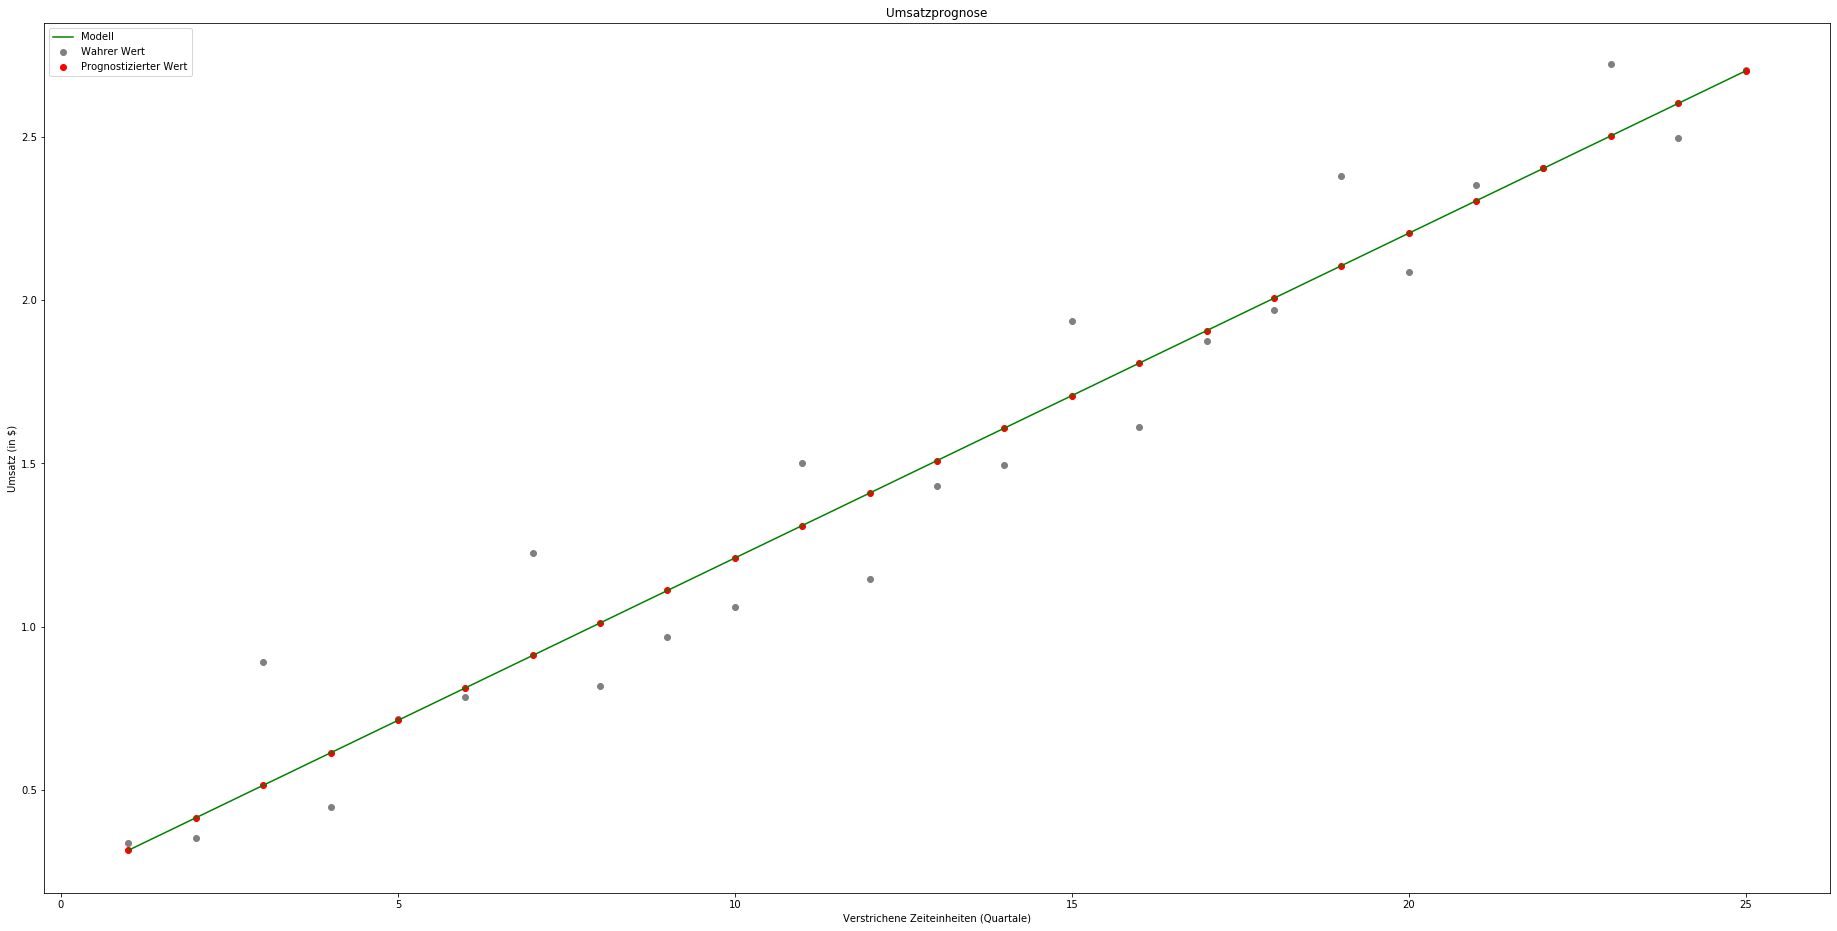

In [9]:
make_plot(model_lin_x1, data_lin.drop('Umsatz',axis='columns'), data_lin.Umsatz)  # plotten der Ergebnisse

## Multivariate lineare Regression

### Definition Funktion für ein multivariates Regressionsmodell

In [10]:
def regression(n, data):
  
    #--------------------------------
    # Erstellen einer Pipeline, die für die Prognose verwendet wird
    prediction_pipe = Pipeline([   
                                ('add_x_square', PolynomialFeatures(degree=n)), # degree wird von der for-Schleife gesetzt
                                ('linear_regression', LinearRegression())])  
    #--------------------------------
    # Trainiertes Modell auf die Ausgangsdaten anwenden 
    prediction_pipe.fit(data.drop('Umsatz',axis='columns'), data.Umsatz)
    pred = prediction_pipe.predict(data.drop('Umsatz',axis='columns'))
    
    #--------------------------------
    # MSE berechnen
    mse = mean_squared_error(data['Umsatz'], pred)
    print("Mean squared error (i=%d): %.7f" % (n, mse))
    
    #----------------------------------------
    # Bestimmtheitsmaß berechnen
    x_ = data['Periode']
    x_reshaped = x_.values.reshape(-1, 1) 
    y_ = data['Umsatz']
    r_square = prediction_pipe.score(x_reshaped, y_)
    print('Train Data R^2: {} \n'.format(r_square))        
    #--------------------------------------------------------------------
    
    return mse, r_square, prediction_pipe

### Ausführung der Funktion "regression" in einer For-Schleife und Dokumentation von MSE und $R^2$
- 0 = Einfache lineare Regression
<br>
- 1 = Regressionsmodell mit den erklärenden Variablen X, X^2
<br>
- 2 = Regressionsmodell mit den erklärenden Variablen X bis X^3
<br>
- ...
<br>
- n = Regressionsmodell mit den erklärenden Variablen X bis X^(n+1)

In [11]:
#--------------------------------
# Zwei leere Listen anlegen 

mse_liste = []
r_squared_liste = []

#--------------------------------
# Die For-Schleife

for i in range(1, 10):
    mse, r_squared, _  = regression(i, data_lin)
    mse_liste.append(mse)
    r_squared_liste.append(r_squared)

#--------------------------------
# Ausgabe der Berechnungen
print('Es wurden folgende MSEs berechnet:\n{}'.format(mse_liste))
print('Der kleinste MSE hat den Index {} (d.h. {} Degrees) und beträgt {}. \n'.format(np.argmin(mse_liste), int(np.argmin(mse_liste) + 1), min(mse_liste)))
print('Es wurden folgende R^2 berechnet:\n{}'.format(r_squared_liste))
print('Das größte R^2 hat den Index {} (d.h. {} Degrees) und beträgt {}.'.format(np.argmax(r_squared_liste), int(np.argmax(r_squared_liste) + 1), max(r_squared_liste)))
best_fit = (np.argmax(r_squared_liste) + 1)

Mean squared error (i=1): 0.0288845
Train Data R^2: 0.9468616996353717 

Mean squared error (i=2): 0.0278743
Train Data R^2: 0.9487201080250651 

Mean squared error (i=3): 0.0275992
Train Data R^2: 0.9492261915724488 

Mean squared error (i=4): 0.0264893
Train Data R^2: 0.9512679865886451 

Mean squared error (i=5): 0.0263844
Train Data R^2: 0.951461017025894 

Mean squared error (i=6): 0.0263681
Train Data R^2: 0.9514910839919535 

Mean squared error (i=7): 0.0263679
Train Data R^2: 0.9514914047869598 

Mean squared error (i=8): 0.0263655
Train Data R^2: 0.9514956916965772 

Mean squared error (i=9): 0.0261702
Train Data R^2: 0.9518550453696364 

Es wurden folgende MSEs berechnet:
[0.02888445249733432, 0.027874275120858077, 0.02759918265301886, 0.02648932157823988, 0.026384395781648754, 0.026368052243241912, 0.02636787786829842, 0.02636554762746733, 0.026170213301228134]
Der kleinste MSE hat den Index 8 (d.h. 9 Degrees) und beträgt 0.026170213301228134. 

Es wurden folgende R^2 berech

### Run des Modells mit dem kleinsten MSE ($X^9$)  / größten $R^2$ 

Mean squared error (i=9): 0.0261702
Train Data R^2: 0.9518550453696364 

    Perioden     Umsatz
17        18   7.476290
18        19   8.352749
19        20   9.418808
20        21  10.662364
21        22  11.915868
22        23  12.874826
23        24  13.450120
24        25  14.645659


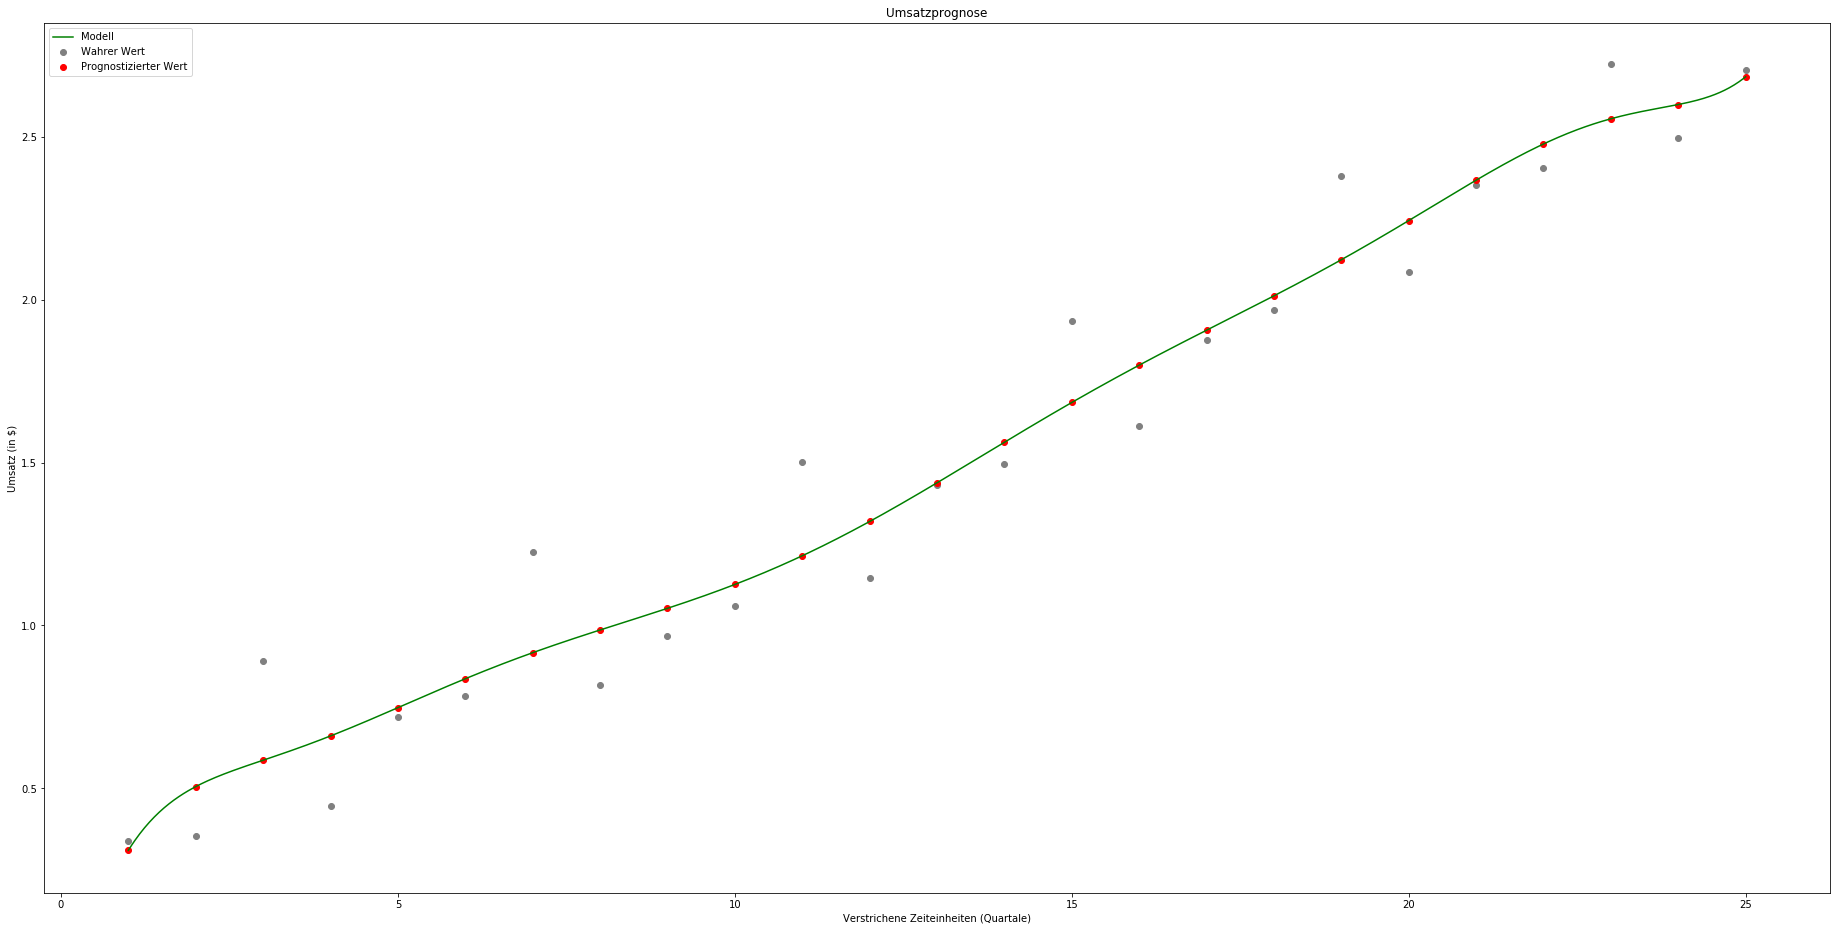

In [12]:
_, _, model_x8 = regression(best_fit, data_lin)
pred = model_x8.predict(data_lin.drop('Umsatz',axis='columns'))

#--------------------------------
# DataFrame mit prognostizierten Umsätzen erzeugen

periods = range(1,len(quartals) + 1)
blank_revenue = [0] * len(quartals)
table_model_x8 = pd.DataFrame({'Perioden':periods, 'Umsatz':np.exp(pred)})
print(table_model_x8.tail(8))

make_plot(model_x8, data_lin.drop('Umsatz',axis='columns'), data_lin.Umsatz) # plotten der Ergebnisse

### Durchführung einer Umsatzprognose auf Basis des Modells

   Perioden         Umsatz
0        26   2.129640e+01
1        27   7.382229e+01
2        28   1.933410e+03
3        29   3.060366e+06
4        30   9.668617e+12
5        31   1.621092e+25
6        32   7.483016e+46
7        33   3.036538e+83
8        34  9.218585e+142
9        35  2.995082e+236


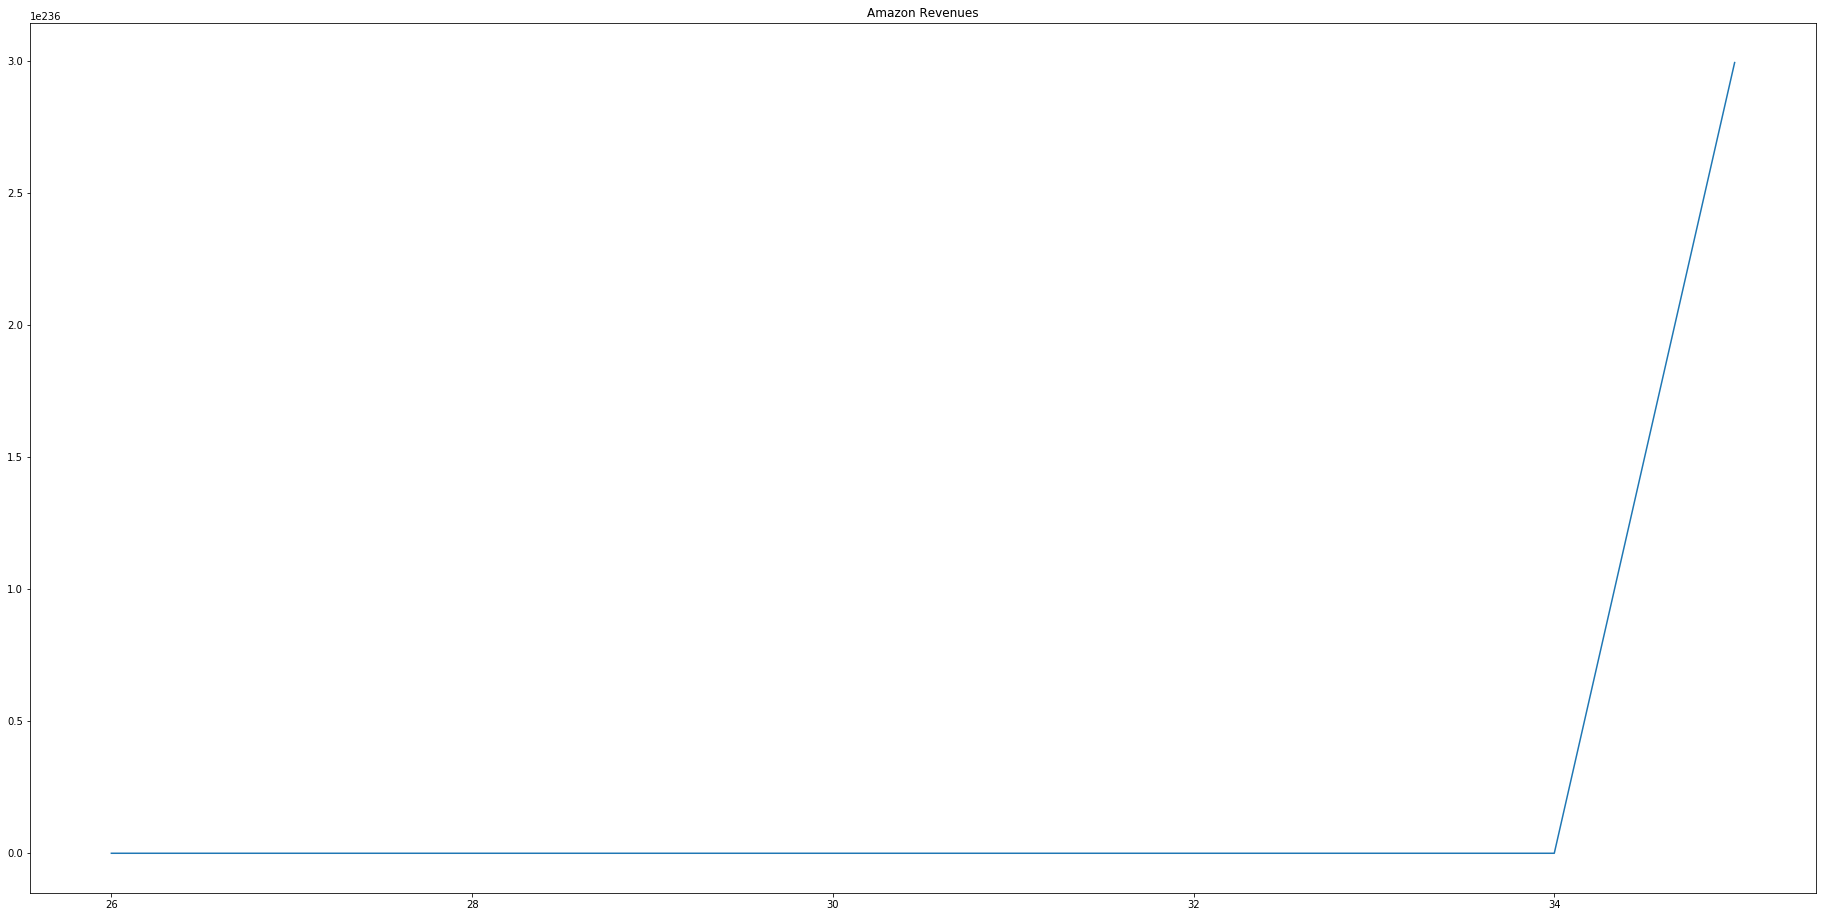

In [13]:
#--------------------------------
# DataFrame ab Periode 39 erzeugen

periods = range(len(quartals) + 1, len(quartals) + 11)
blank_revenue = [0] * 10
pred_table_model_x8 = pd.DataFrame({'Perioden':periods, 'Umsatz':blank_revenue})

#--------------------------------------------------------------------
# Prognose auf Basis des Modells

pred = model_x8.predict(pred_table_model_x8.drop('Umsatz',axis='columns'))
pred_table_model_x8['Umsatz'] = np.exp(pred)
print(pred_table_model_x8)

#--------------------------------
# Plotten des prognostizierten Umsatzverlaufes 

plt.plot(pred_table_model_x8.Perioden, pred_table_model_x8.Umsatz)
plt.title("Amazon Revenues")
plt.show()

### Alternatives Modell

Mean squared error (i=3): 0.0275992
Train Data R^2: 0.9492261915724488 

    Perioden     Umsatz
17        18   7.439454
18        19   8.280942
19        20   9.211392
20        21  10.235985
21        22  11.359124
22        23  12.584119
23        24  13.912833
24        25  15.345290


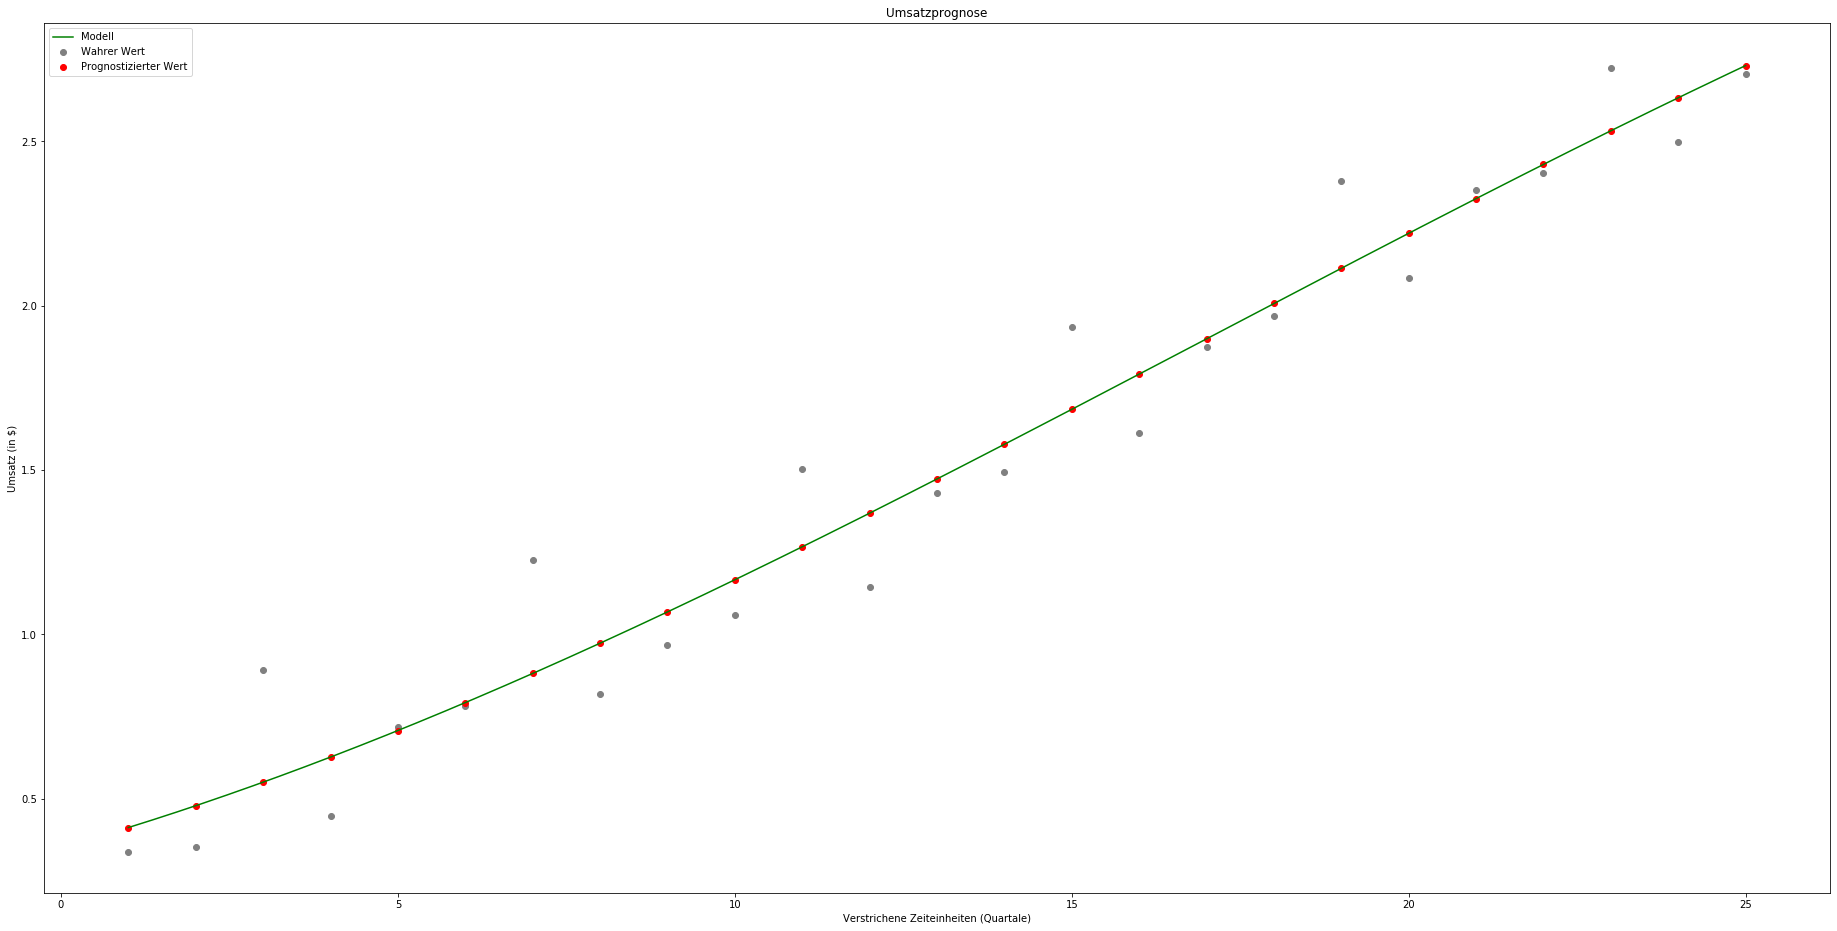

   Perioden     Umsatz
0        26  16.879257
1        27  18.509824
2        28  20.228978
3        29  22.025219
4        30  23.883238
5        31  25.783673
6        32  27.703010
7        33  29.613635
8        34  31.484082
9        35  33.279507


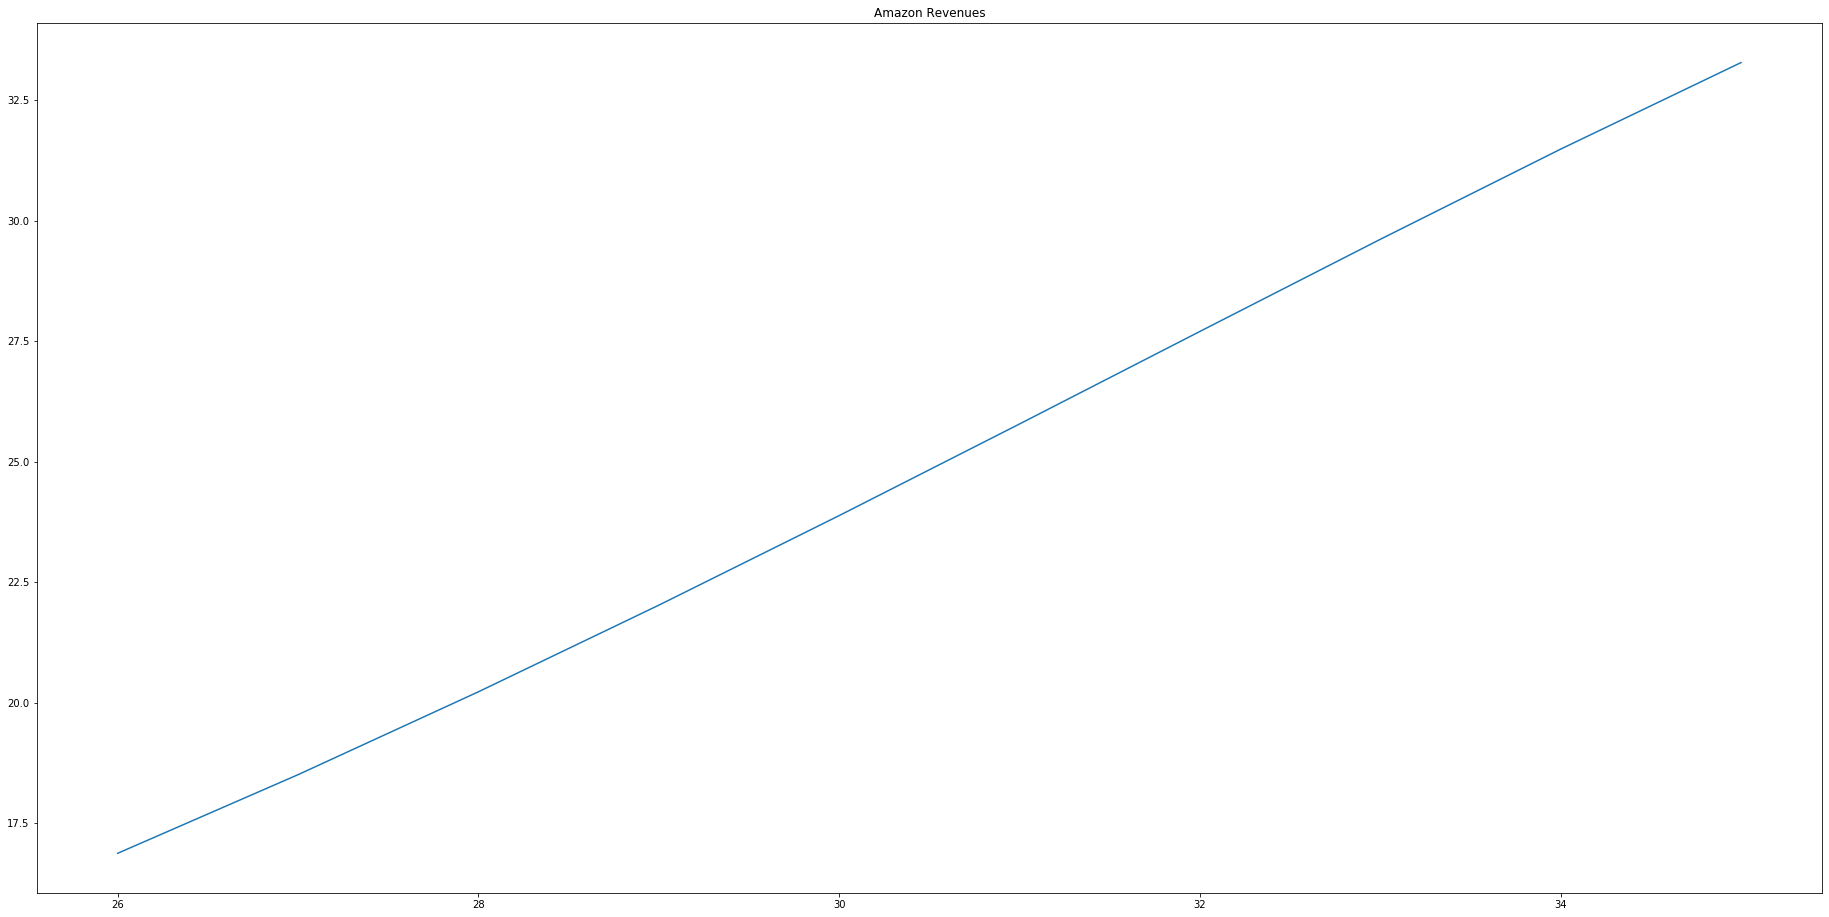

In [14]:
_, _, model_x4 = regression(3, data_lin)
pred = model_x4.predict(data_lin.drop('Umsatz',axis='columns'))

#--------------------------------
# DataFrame mit prognostizierten Umsätzen erzeugen

periods = range(1,len(quartals) + 1)
blank_revenue = [0] * len(quartals)
table_model_x4 = pd.DataFrame({'Perioden':periods, 'Umsatz':np.exp(pred)})
print(table_model_x4.tail(8))
make_plot(model_x4, data_lin.drop('Umsatz',axis='columns'), data_lin.Umsatz) # plotten der Ergebnisse

#--------------------------------
# DataFrame ab Periode 39 erzeugen

"""
# Ohne 4. Quartal
periods = range(39,45)
"""

periods = range(len(quartals) + 1, len(quartals) + 11)
blank_revenue = [0] * 10
pred_table_model_x4 = pd.DataFrame({'Perioden':periods, 'Umsatz':blank_revenue})

#--------------------------------------------------------------------
# Prognose auf Basis des Modells

pred = model_x4.predict(pred_table_model_x4.drop('Umsatz',axis='columns'))
pred_table_model_x4['Umsatz'] = np.exp(pred)
print(pred_table_model_x4)

#--------------------------------
# Plotten des prognostizierten Umsatzverlaufes 

plt.plot(pred_table_model_x4.Perioden, pred_table_model_x4.Umsatz)
plt.title("Amazon Revenues")
plt.show()

## Analyse von Zeitreihen mit Prophet

### Ausgangsdaten (sicherheitshalber) inkl. des 4. Quartals neu definieren

In [15]:
#----------------------------------------
# DataFrame erzeugen

prophet_data = pd.DataFrame({'Periode':quartals_new, 'Umsatz':revenues})
prophet_data['Periode'] = pd.to_datetime(prophet_data['Periode'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')
prophet_data.tail()

,Periode,Umsatz
20,2018-04-01,2.353240
21,2018-07-01,2.404170
22,2018-10-01,2.724326
23,2019-01-01,2.497719
24,2019-04-01,2.704050


### DataFrame für Prophet interpretierbar machen und Verlauf plotten

           ds         y
15 2017-01-01  1.612487
16 2017-04-01  1.875475
17 2017-07-01  1.969328
18 2017-10-01  2.378957
19 2018-01-01  2.085816
20 2018-04-01  2.353240
21 2018-07-01  2.404170
22 2018-10-01  2.724326
23 2019-01-01  2.497719
24 2019-04-01  2.704050


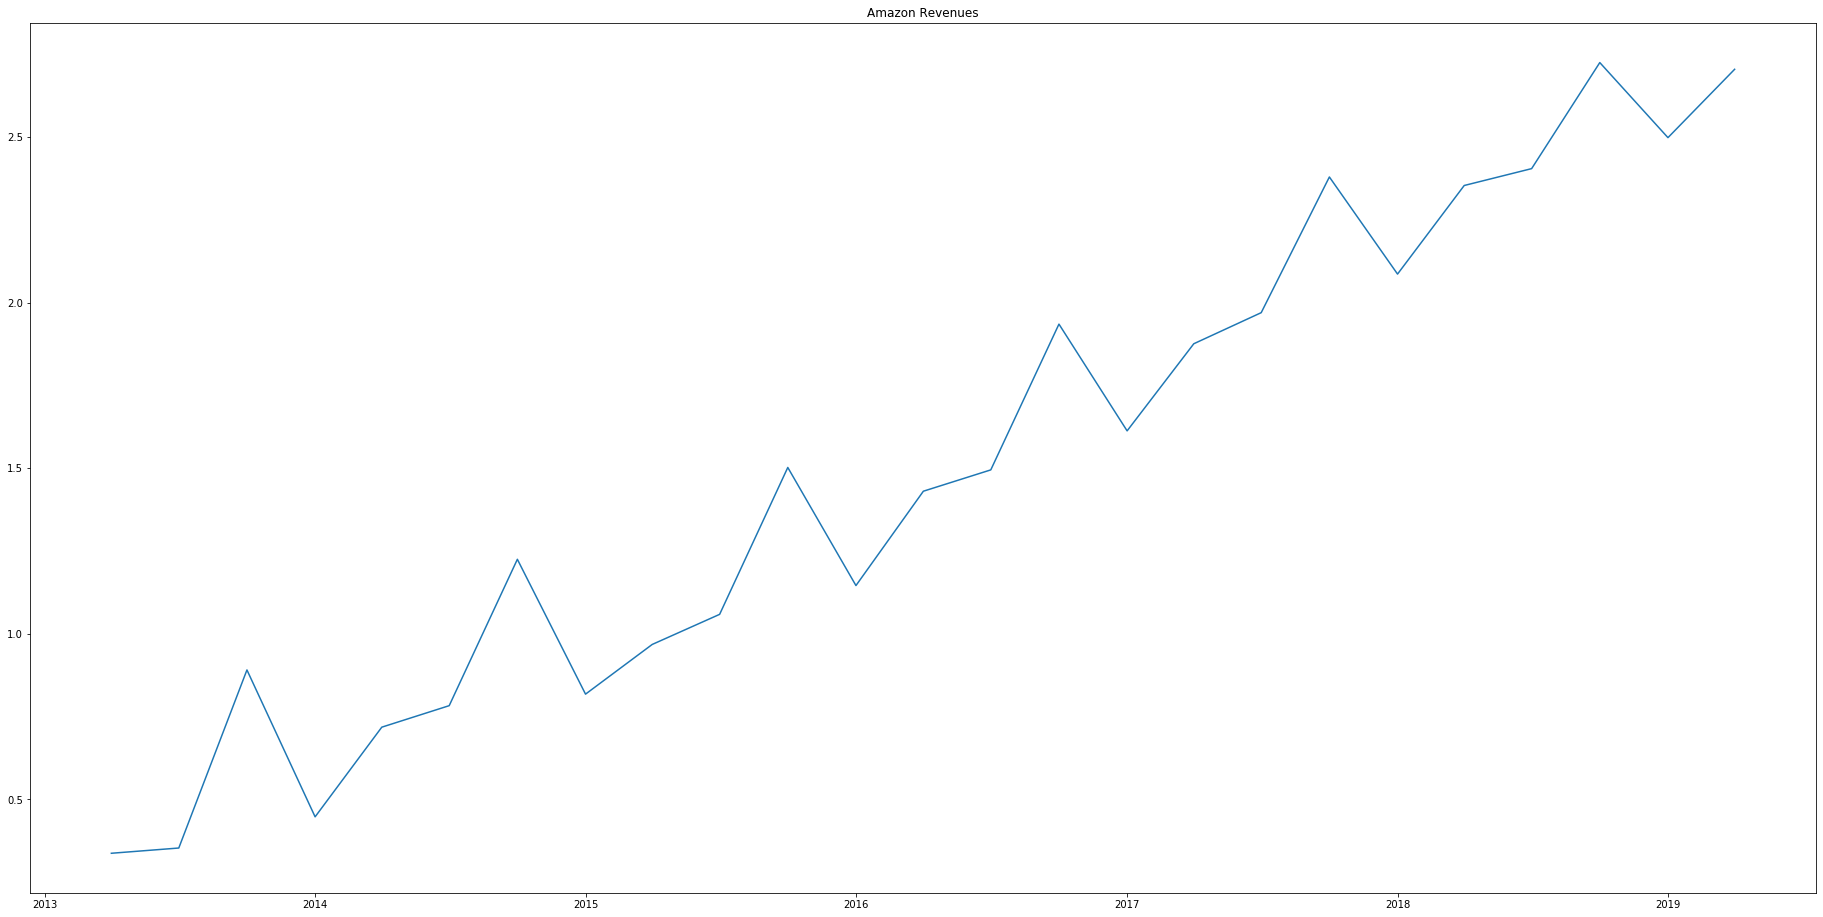

In [16]:
#----------------------------------------
# Spalten umbenennen

df = prophet_data[['Periode','Umsatz']]
df.columns = ['ds','y']
print(df.tail(10))

#----------------------------------------
# Plott generieren
plt.plot(df.ds, df.y)
plt.title("Amazon Revenues")
plt.show()

### Datensatz in Test- und Trainingsdatensatz unterteilen und Modell auf Trainings-Daten fitten

In [17]:
#----------------------------------------
# Test-Datensatz
future = df.tail(6)
future = future.drop('y', axis=1)

#----------------------------------------
# Trainings-Datensatz
df.drop(df.tail(6).index,inplace=True)

#----------------------------------------
# Fitten des Modells auf die Trainingsdaten
prophet_model = Prophet(weekly_seasonality=False, daily_seasonality=False)
prophet_model.add_seasonality(name='quartal', period=365.25/4, fourier_order=10)
#prophet_model.add_seasonality(name='quarterly', period=1, fourier_order=10)
prophet_model.fit(df)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:n_changepoints greater than number of observations.Using 14.


### Forecast erzeugen und plotten

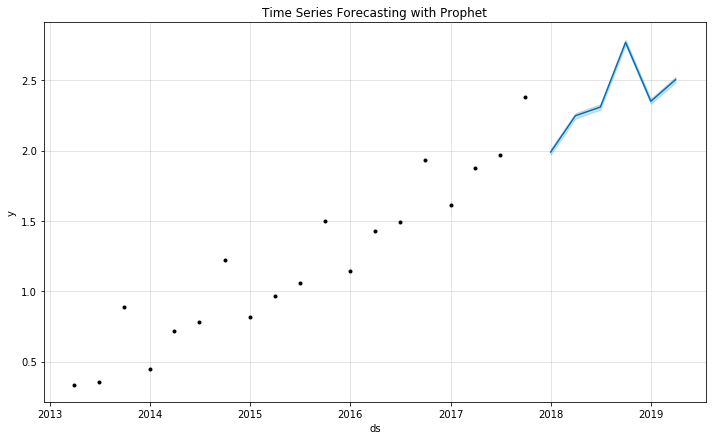

In [18]:
forecast = prophet_model.predict(future)

#----------------------------------------
# Plotten
prophet_model.plot(forecast)
plt.title("Time Series Forecasting with Prophet")
plt.show()

### Modellkomponenten betrachten

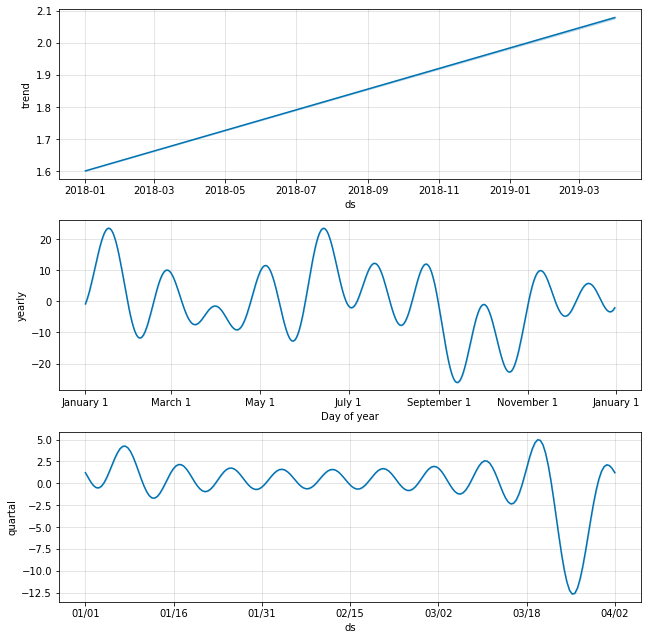

In [19]:
prophet_model.plot_components(forecast);

In [20]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,1.989415,1.970912,2.009670
1,2018-04-01,2.247196,2.226401,2.265756
2,2018-07-01,2.308686,2.289875,2.328904
3,2018-10-01,2.768455,2.748910,2.787866
4,2019-01-01,2.349915,2.330767,2.368931
5,2019-04-01,2.503409,2.483128,2.523869


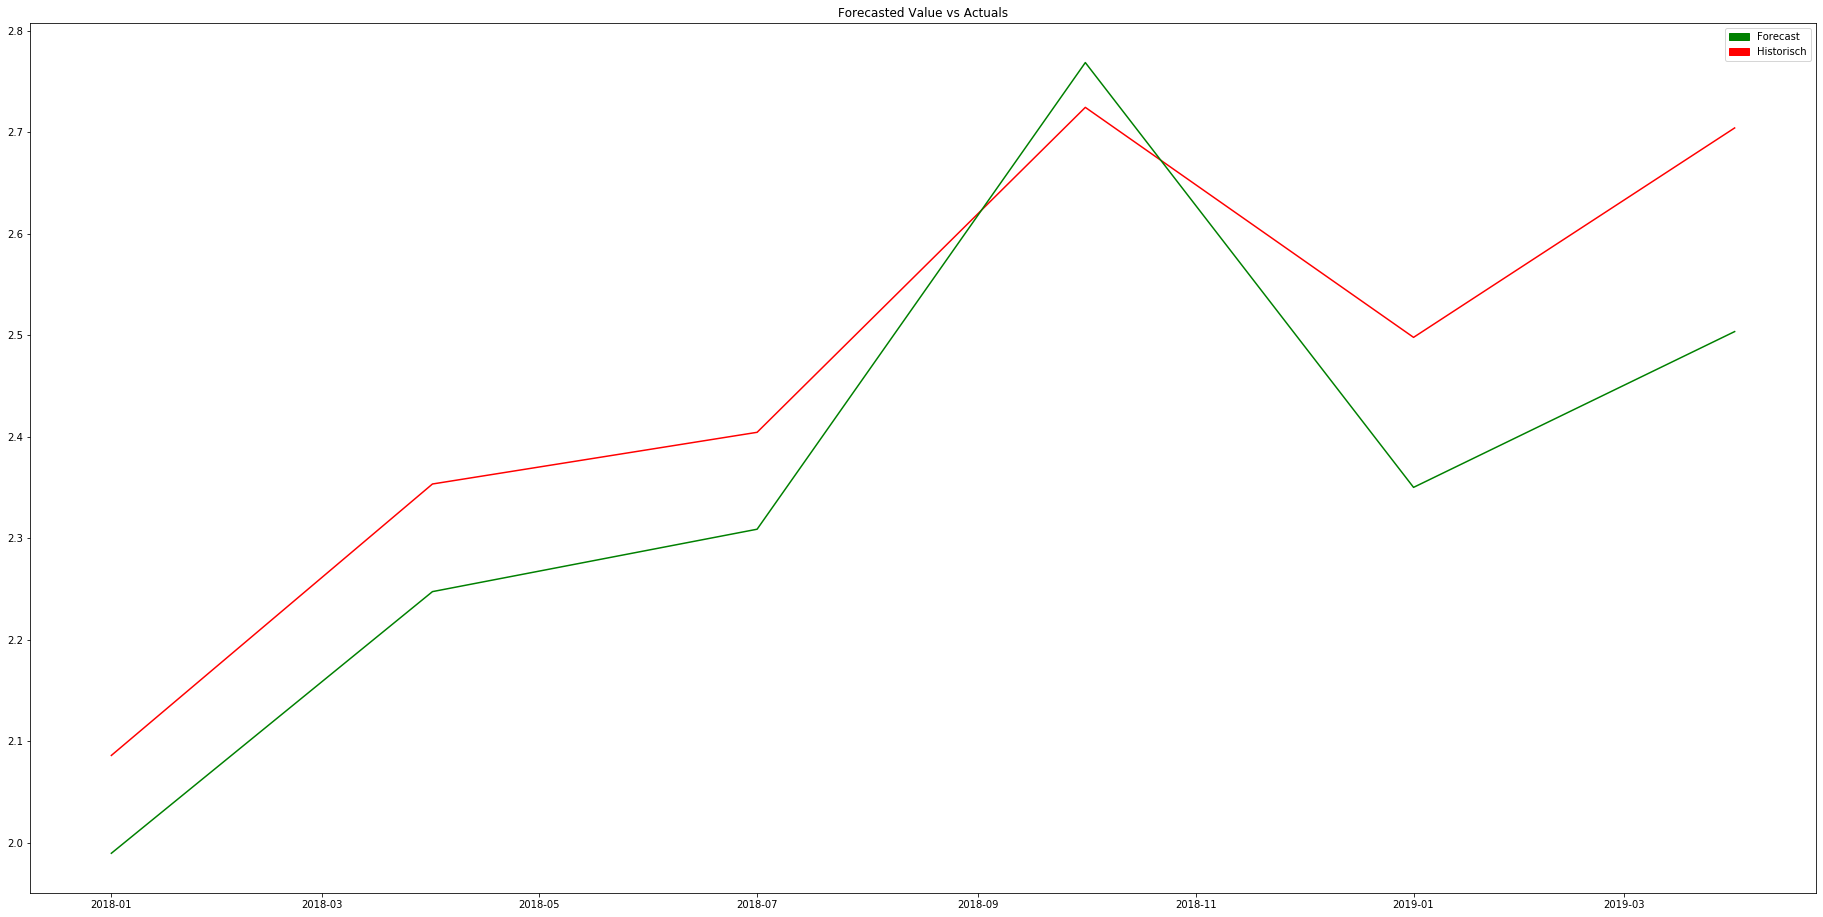

In [21]:
#----------------------------------------
# Forecast DataFrame und Original-DataFrame 

dfForecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
yActual = prophet_data.tail(6)['Umsatz'].values.tolist()
yPredicted = dfForecast['yhat'].values.tolist()

#----------------------------------------
# Plot Prognose vs. Original

plt.plot(dfForecast.ds,yActual, color='red') # Rot
plt.plot(dfForecast.ds,yPredicted, color='green') # Grün
green_patch = mpatches.Patch(color='green', label='Forecast') 
red_patch = mpatches.Patch(color='red', label='Historisch') 
plt.legend(handles=[green_patch, red_patch])
plt.title("Forecasted Value vs Actuals")
plt.show()

### Durchführung einer Umsatzprognose auf Basis des Modells

          ds  y_original  y_Prophet  y_lin_reg_4-degree  y_lin_reg_8-degree  PctChg
0 2017-07-01     7.16586   6.953772            7.439454            7.476290    2.96
1 2017-10-01    10.79364  11.027847            8.280942            8.352749   -2.17
2 2018-01-01     8.05116   7.311255            9.211392            9.418808    9.19
3 2018-04-01    10.51960   9.461172           10.235985           10.662364   10.06
4 2018-07-01    11.06924  10.061200           11.359124           11.915868    9.11
5 2018-10-01    15.24614  15.933998           12.584119           12.874826   -4.51
6 2019-01-01    12.15474  10.484683           13.912833           13.450120   13.74
7 2019-04-01    14.94012  12.224093           15.345290           14.645659   18.18


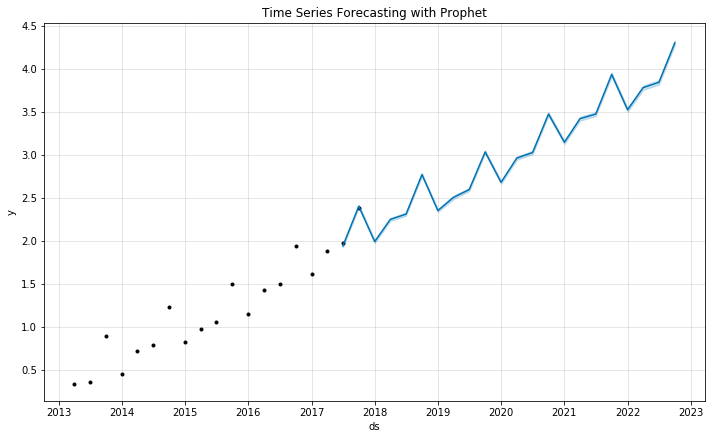

In [22]:
position = (len(quartals) - 8)
position_item = quartals[position]
position_quartal = position_item[:2]
#print(position_item)
#print(position_quartal)
position_item_year = int(position_item[3:])

#----------------------------------------
# Quatal-Liste erzeugen und Forecast-DataFrame erzeugen

counter = 0
future_quartals = []
ending = np.array(['Q1','Q2','Q3','Q4'])
position_item_quartal = np.argwhere(ending == position_quartal)[0][0]
#print(position_item_quartal)
for i in range(position_item_year, position_item_year + 6): 
    for q in ending:
        x = '20' + str(i)
        z = str(x) + '-' + str(q)
        future_quartals.append(z)
future_quartals = future_quartals[position_item_quartal:]
#print(future_quartals)

#----------------------------------------
# DataFrame für die Perioden ab 2019-Q3 erstellen
df_predict = pd.DataFrame({'ds':future_quartals})
df_predict['ds'] = pd.to_datetime(df_predict['ds'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')

#--------------------------------------------------------------------
# Prognose für "future_quartals" erstellen und dem "df_predict"-DataFrame anfügen
forecast = prophet_model.predict(df_predict)
df_predict['Pred'] = np.exp(forecast['yhat'])

#----------------------------------------
# Daten zusammentragen
original_data_values = original_data['Umsatz'][len(original_data)-8:].values.tolist()
df_predict_values = df_predict['Pred'][:8].values.tolist()
model_x4_values = table_model_x4['Umsatz'][len(original_data)-8:].values.tolist()
model_x8_values = table_model_x8['Umsatz'][len(original_data)-8:].values.tolist()
#----------------
#print(original_data[len(original_data)-8:])
#print(df_predict[:8])
#print(table_model_x4[len(original_data)-8:])
#print(table_model_x8[len(original_data)-8:])

#--------------------------------------------------------------------
# Originaldaten als Vergleich
compare_df = pd.DataFrame({'ds':future_quartals[:8]})
compare_df['ds'] = pd.to_datetime(compare_df['ds'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors='coerce')
compare_df['y_original'] = original_data_values
compare_df['y_Prophet'] = df_predict_values
compare_df['y_lin_reg_4-degree'] = model_x4_values
compare_df['y_lin_reg_8-degree'] = model_x8_values
compare_df['PctChg'] = round(((compare_df.y_original - compare_df.y_Prophet) / compare_df.y_original * 100), 2)
print(compare_df)

#----------------------------------------
# Plotten des Forecasts

prophet_model.plot(forecast)
plt.plot()
plt.title("Time Series Forecasting with Prophet")
plt.show()

### Umsatzprognose für die nächsten Qurtale auf Basis des besten Modells

In [23]:
df_predict[8:]

,ds,Pred
8,2019-07-01,13.382970
9,2019-10-01,20.750154
10,2020-01-01,14.568000
11,2020-04-01,19.317101
12,2020-07-01,20.589131
13,2020-10-01,32.234061
14,2021-01-01,23.216035
15,2021-04-01,30.541065
16,2021-07-01,32.219558
17,2021-10-01,51.096351
